# Test validity partial step 4 : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (C_{approx} + B^T N^{-1} B)^{-1}  N_c^{1/2} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from functools import partial
import micmac as micmac
# from mcmc_tools import *

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
# from get_freq_maps_SO_64 import *
from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(15, 2, 49152)
(15, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,40.0,37.42,26.46,70.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
1,50.0,33.46,23.66,58.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
2,60.0,21.31,15.07,51.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
3,68.0,16.87,11.93,47.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
4,78.0,12.07,8.53,43.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
5,89.0,11.30,7.99,41.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
6,100.0,6.56,4.64,37.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
7,119.0,4.58,3.24,33.6,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
8,140.0,4.79,3.39,30.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
9,166.0,5.57,3.94,28.9,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD


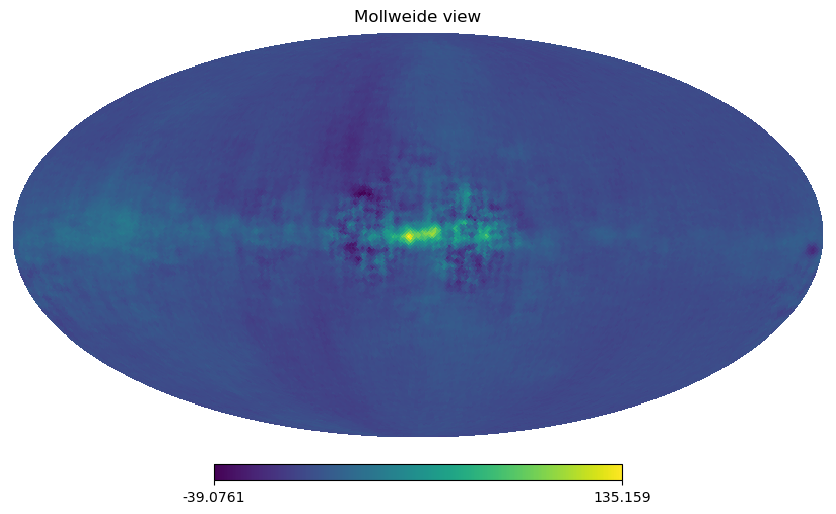

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [8]:
init_params.shape

(13, 2)

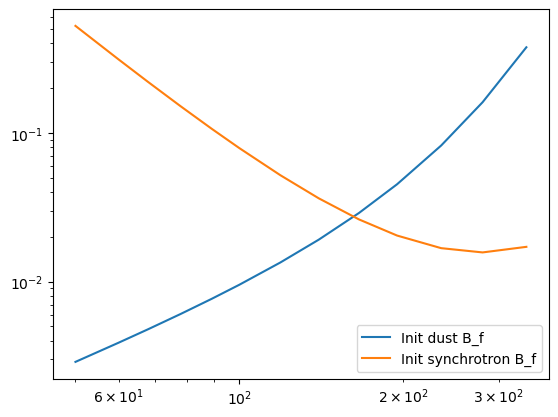

In [9]:
frequency_Bf = instrument['frequency'][1:-1]

plt.plot(frequency_Bf, init_params[:,0], label='Init dust B_f')
plt.plot(frequency_Bf, init_params[:,1], label='Init synchrotron B_f')
plt.legend()
plt.loglog()
plt.show()

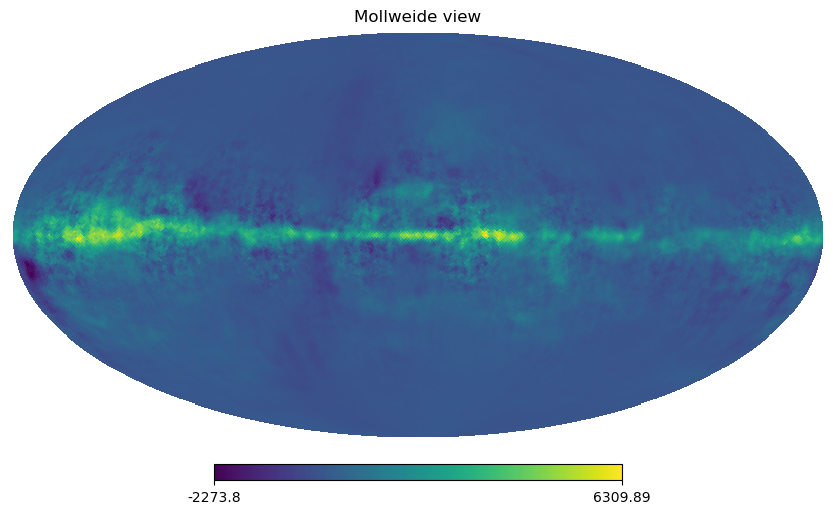

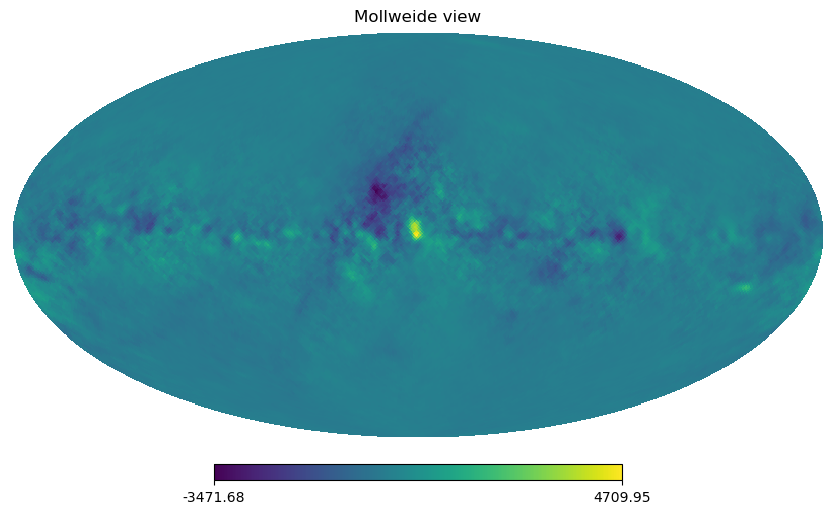

In [10]:
maps_cpnt = np.einsum('cf,fsp->csp', mixing_matrix_sampled.T, freq_maps)

hp.mollview(maps_cpnt[0][0])
hp.mollview(maps_cpnt[0][1])

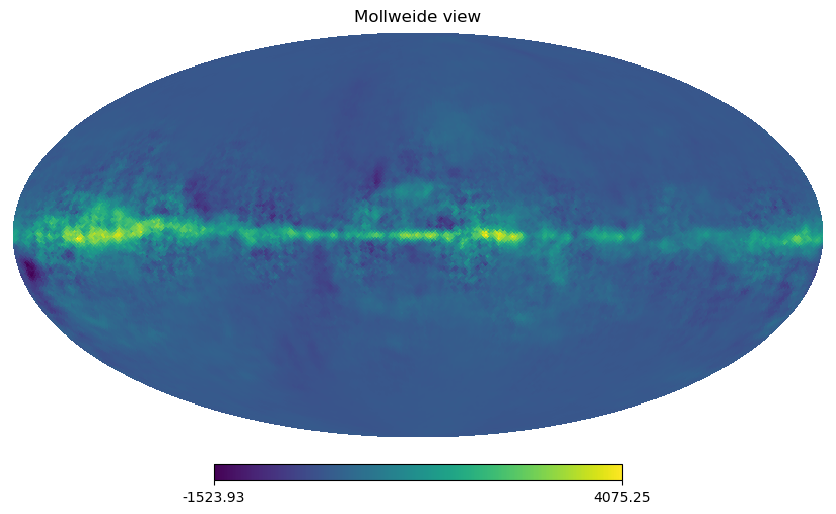

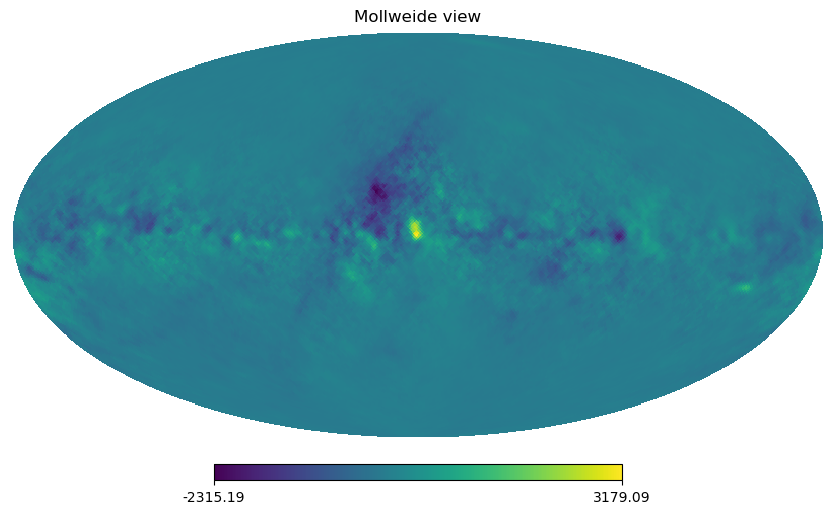

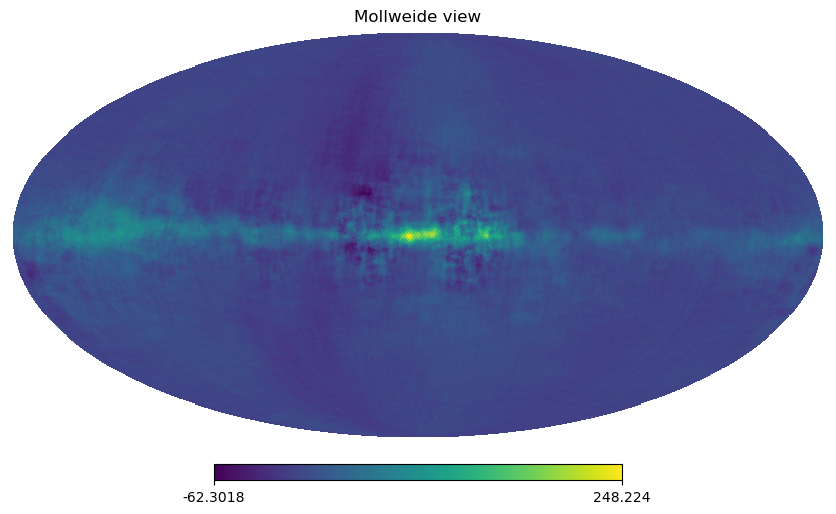

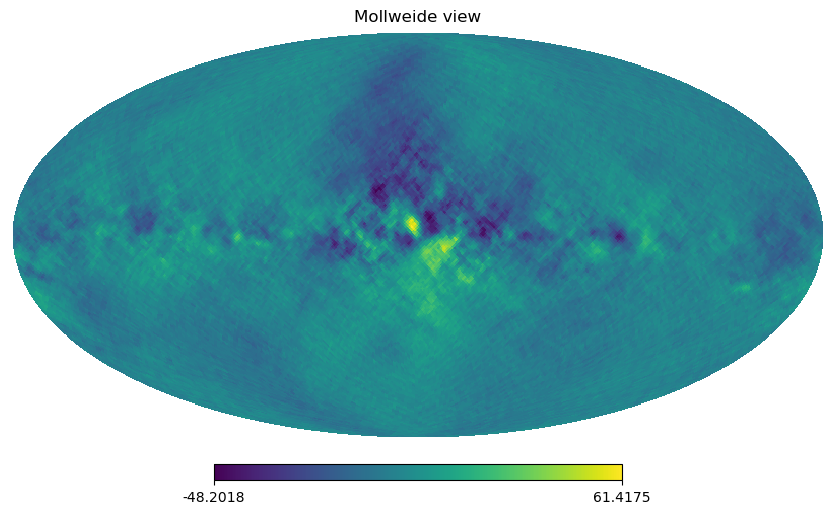

In [11]:
hp.mollview(maps_cpnt[1][0])
hp.mollview(maps_cpnt[1][1])
hp.mollview(maps_cpnt[2][0])
hp.mollview(maps_cpnt[2][1])

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [12]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
Recalculating x !
Recalculating y !
CPU times: user 722 ms, sys: 149 ms, total: 871 ms
Wall time: 182 ms


## Constrained map realization $s_c$ : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (S_c + E^t (B^t N^{-1} B)^{-1} E)^{-1} (s_c - s_{c,ML})$

In [13]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

### Fluctuation part

In [14]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  233 iterations !!
CPU times: user 33.1 s, sys: 3.42 s, total: 36.5 s
Wall time: 5.16 s


### Wiener filter part

In [15]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = micmac.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  252 iterations !!
CPU times: user 36.5 s, sys: 3.84 s, total: 40.3 s
Wall time: 5.82 s


In [16]:
s_c_map = wiener_filter_term + fluctuation_maps

## Sampling $C$ through inverse Wishart sampling : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$

In [17]:
%%time
c_ells_Wishart = micmac.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)


CPU times: user 137 ms, sys: 24.4 ms, total: 161 ms
Wall time: 31 ms


In [18]:
%%time
red_c_ells_inv_Wishart_sample = np.zeros((lmax+1, nstokes, nstokes))
c_ells_inv_Wishart_sample = np.zeros((number_correlations, lmax+1))

red_c_ells_inv_Wishart_sample = micmac.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
c_ells_inv_Wishart_sample = micmac.get_c_ells_from_red_covariance_matrix(red_c_ells_inv_Wishart_sample)

CPU times: user 39 ms, sys: 16.9 ms, total: 55.9 ms
Wall time: 11.4 ms


## Few statistics before sampling $\bold{B_f}$ 

## Sampling $\bold{B_f}$ : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (C_{approx} + E^t (B^T N^{-1} B)^{-1} E)^{-1} N_c^{1/2} \eta$

In [19]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()

full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [20]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean FG', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.log(np.linalg.det(cp_cp_noise)))

[[0.         0.00778423 0.02581475 0.05075681 0.12550375 0.18118873
  0.66801792 1.93593892 2.52022378 2.8181711  3.98374514 2.13339904
  2.54865311 2.35908526 1.34197369]
 [2.15778848 1.41393232 2.07454769 2.33367924 3.13362704 2.51955412
  5.54829428 7.47503514 4.77783258 2.54838312 1.80020096 0.43534911
  0.24915785 0.10737359 0.        ]] (2, 15) (15, 2, 49152)
d-Bcsc -- mean 9.055058961063848 max 3459.818700476614 min -1966.3166986508215
B_fN^{-1} (d-Bcsc) - mean 144.83591141043686 max 10996.509283374971 min -6209.866061254694
B_fN^{-1} - mean 1.9091670580479396 max 7.475035143860341 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean FG 0.10787996205566348 max 0.322343873052212 min -0.03145960092805792
(B_f^t N^{-1} B_f)^{-1} - mean -8.699422931664065


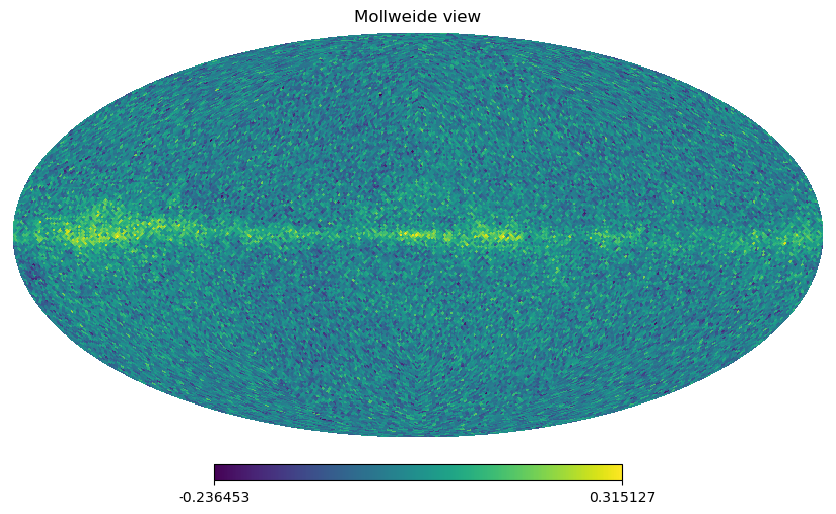

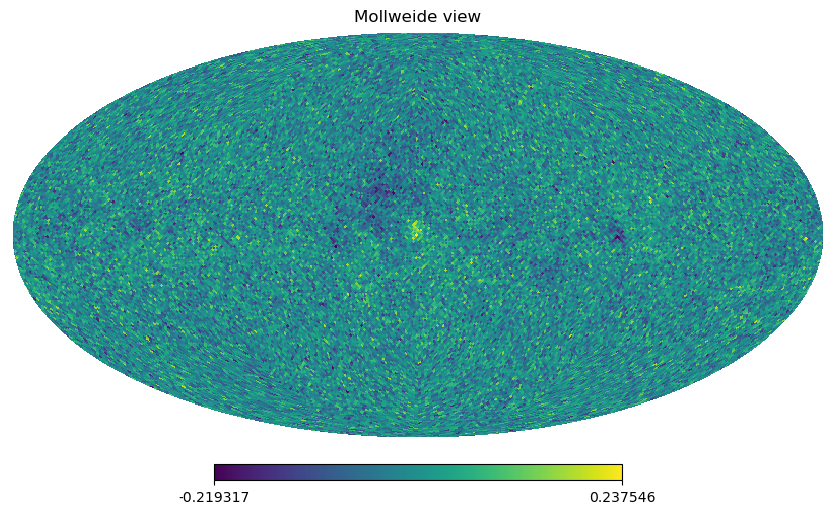

In [21]:
first_residual = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]
hp.mollview(first_residual[0])
hp.mollview(first_residual[1])

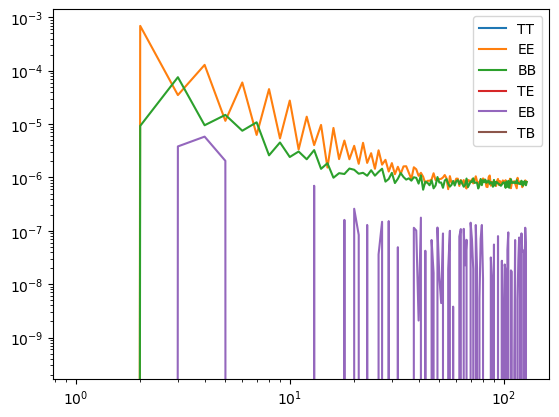

In [22]:
c_ell_first_residual = hp.anafast(np.vstack([np.zeros_like(first_residual[0]),first_residual]), lmax=lmax, iter=n_iter)
ell_arange = np.arange(c_ell_first_residual.shape[1])
plt.plot(ell_arange, c_ell_first_residual.T)
# plt.plot(ell_arange, np.abs(c_ell_first_residual).T)
plt.loglog()
plt.legend(['TT', 'EE', 'BB', 'TE', 'EB', 'TB'])
plt.show()

In [23]:
regularization_constant = -10**(12)

In [24]:
@partial(jax.jit, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant'])
def get_conditional_proba_spectral_likelihood_JAX(complete_mixing_matrix, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False, regularization_constant=-10**12):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    # Building the spectral_likelihood : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    complete_mixing_matrix_fg = complete_mixing_matrix[:,1:]

    cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)
    cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, cp_cp_noise_fg, full_data_without_CMB_with_noise)

    return -(-first_term_complete + 0)/2. + regularization_constant

def new_get_conditional_proba_spectral_likelihood_JAX(params_mixing_matrix, pos_special_freqs=[-1,0], **model_kwargs):
    new_mixing_matrix = micmac.create_mixing_matrix_jax(params_mixing_matrix, param_dict['number_components'], param_dict['number_frequencies'], pos_special_freqs=pos_special_freqs)
    return get_conditional_proba_spectral_likelihood_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(model_kwargs['eta_prime_maps']), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'], regularization_constant=model_kwargs['regularization_constant'])



In [25]:
%%time

# Calculation value log_proba with current value of B_f

# log_proba = micmac.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = new_get_conditional_proba_spectral_likelihood_JAX(mixing_matrix_obj.params, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

Log_proba : -982833911340.764
<-> Proba : 0.0
CPU times: user 666 ms, sys: 34.1 ms, total: 700 ms
Wall time: 678 ms


In [26]:
# @partial(jax.jit, static_argnames=['number_components', 'number_frequencies'])
# def create_mixing_matrix_jax_2(params_mixing_matrix, number_components, number_frequencies, pos_special_freqs=[-1,0]):
#     # number_frequencies = params_mixing_matrix.shape[0] + 2
#     # number_components = params_mixing_matrix.shape[1] + 1

#     new_mixing_matrix = jnp.zeros((number_frequencies,number_components))
    
#     twice_arange = jnp.repeat(jnp.arange(number_frequencies),2,axis=0).reshape(2,number_frequencies,order='F')

#     new_mixing_matrix = new_mixing_matrix.at[:,1:].set(jnp.where(jnp.isin(twice_arange, jnp.array(pos_special_freqs), assume_unique=False), 
#                                                                 params_mixing_matrix, 0))

#     new_mixing_matrix = new_mixing_matrix.at[:,0].set(1)
#     # new_mixing_matrix[0,1] = 0
#     # new_mixing_matrix[-1,-1] = 0
#     # new_mixing_matrix[1:,1:-1] = jnp.array(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))

#     for c in range(number_components-1):
#         new_mixing_matrix = new_mixing_matrix.at[pos_special_freqs[c],c].set(1)
#     # new_mixing_matrix = new_mixing_matrix.at[0,1].set(0)
#     # new_mixing_matrix = new_mixing_matrix.at[-1,-1].set(0)

#     # all_indexes_bool = jnp.ones(number_frequencies, dtype=bool)
#     # all_indexes_bool[pos_special_freqs] = False

#     # all_indexes_bool = all_indexes_bool.at[pos_special_freqs].set(False)
#     # all_indexes_bool = all_indexes_bool.at[pos_special_freqs].set(False)

#     all_indexes_bool = jnp.isin(jnp.arange(number_frequencies), jnp.array(pos_special_freqs), assume_unique=True)

    
#     # new_mixing_matrix = new_mixing_matrix.at[1:-1,1:].set(jnp.array(params_mixing_matrix.reshape((number_frequencies-2,number_components-1),order='F')))
#     new_mixing_matrix = new_mixing_matrix.at[all_indexes_bool,1:].set(jnp.array(params_mixing_matrix.reshape((number_frequencies-2,number_components-1),order='F')))
#     return new_mixing_matrix

# jitted_create_mixing_matrix_jax_2 = jax.jit(create_mixing_matrix_jax_2, static_argnums=(1,2,))

# twice_arange = jnp.repeat(jnp.arange(number_frequencies),2,axis=0).reshape(2,number_frequencies,order='F')
# jnp.isin(twice_arange, jnp.array([-1,0]))
# params_to_fill = jnp.where(jnp.isin(jnp.arange(number_frequencies)))
# jnp.where(jnp.isin(twice_arange.T, jnp.array([-1,0]), assume_unique=False), 0, y=jnp.array(init_params))
# np.isin(np.array([0,1,2]), [-1,0])
# test_mixing_mat = jitted_create_mixing_matrix_jax_2(mixing_matrix_obj.params, number_components, number_frequencies, pos_special_freqs=[-1,0])

In [27]:
jitted_new_get_conditional_proba_spectral_likelihood_JAX = jax.jit(new_get_conditional_proba_spectral_likelihood_JAX, static_argnames=['with_prints'])

In [28]:
%%time

# Calculation value log_proba with current value of B_f
log_proba = jitted_new_get_conditional_proba_spectral_likelihood_JAX(mixing_matrix_obj.params, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

Log_proba : -982833911340.764
<-> Proba : 0.0
CPU times: user 181 ms, sys: 26.7 ms, total: 208 ms
Wall time: 202 ms


In [29]:
with_prints = False

number_steps_sampler = 50000
n_walkers = 1

kernel = MetropolisHastings_log(new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.1)
# kernel = MetropolisHastings(new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.1)
# kernel = MetropolisHastings(new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.5)
# kernel = MetropolisHastings(jitted_new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.5)
mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


In [42]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel(order='F')
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
full_initial_guess = np.copy(initial_guess_fg_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.05,high=initial_guess_fg_mixing_matrix*10.05, size=(n_walkers,dimensions_mixing_matrix))

# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)
print(mixing_matrix_obj.params, full_initial_guess)

[[0.00288437 0.52391889]
 [0.00387988 0.3117984 ]
 [0.00478088 0.21981377]
 [0.00605139 0.15109337]
 [0.00765723 0.10647904]
 [0.00951436 0.07902249]
 [0.01344021 0.05189527]
 [0.01913787 0.03628152]
 [0.02893752 0.02616729]
 [0.04512184 0.02038996]
 [0.08220506 0.01677506]
 [0.16063955 0.01570422]
 [0.37618047 0.01712183]] [0.00288437 0.00387988 0.00478088 0.00605139 0.00765723 0.00951436
 0.01344021 0.01913787 0.02893752 0.04512184 0.08220506 0.16063955
 0.37618047 0.52391889 0.3117984  0.21981377 0.15109337 0.10647904
 0.07902249 0.05189527 0.03628152 0.02616729 0.02038996 0.01677506
 0.01570422 0.01712183]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

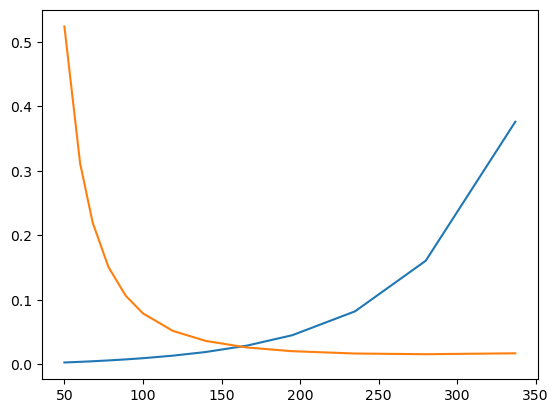

In [43]:
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='init dust values')
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T, label='init synchrotron values')

plt.plot(frequency_Bf, full_initial_guess[:,:int(dimensions_mixing_matrix/2)].T, '-.', label='init dust pre-sampling')
plt.plot(frequency_Bf, full_initial_guess[:,int(dimensions_mixing_matrix/2):].T, '-.', label='init synchrotron pre-sampling')
plt.loglog()
plt.legend()
plt.title('Initial guess values')
plt.show()

In [44]:
%%time 
mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints, regularization_constant=regularization_constant)
samples = mcmc.get_samples(group_by_chain=True)
mcmc.print_summary()


sample: 100%|██████████| 50000/50000 [02:54<00:00, 287.22it/s]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
 Param:0[1]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
 Param:0[2]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
 Param:0[3]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[4]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[5]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[6]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[7]      0.02      0.00      0.02      0.02      0.02      0.50      1.00
 Param:0[8]      0.03      0.00      0.03      0.03      0.03      0.50      1.00
 Param:0[9]      0.05      0.00      0.05      0.05      0.05      0.50      1.00
Param:0[10]      0.08      0.00      0.08      0.08      0.08      0.50      1.00
Param:0[11]    

In [45]:
samples.shape

(1, 50000, 26)

In [47]:
# log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(samples[0,i,0,:], pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for i in range(number_steps_sampler)]
log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(samples[0,i,:], pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for i in range(number_steps_sampler)]

In [48]:
log_proba_samples = np.array(log_proba_samples_list)/log_proba_samples_list[0]

In [50]:
# number_element_column = int(samples.shape[2]/2)

number_element_column = int(samples.shape[-1]/2)
# component_dust = samples[:,:,:,:number_element_column].reshape(number_steps_sampler, number_element_column)
# component_synchrotron = samples[:,:,:,number_element_column:].reshape(number_steps_sampler, number_element_column)
# # component_synchrotron = samples[:,:,:,number_element_column:].reshape(number_steps_sampler, number_element_column, order='F')

component_dust = samples[:,:,:number_element_column].reshape(number_steps_sampler, number_element_column)
component_synchrotron = samples[:,:,number_element_column:].reshape(number_steps_sampler, number_element_column)


print(component_dust.shape)

(50000, 13)


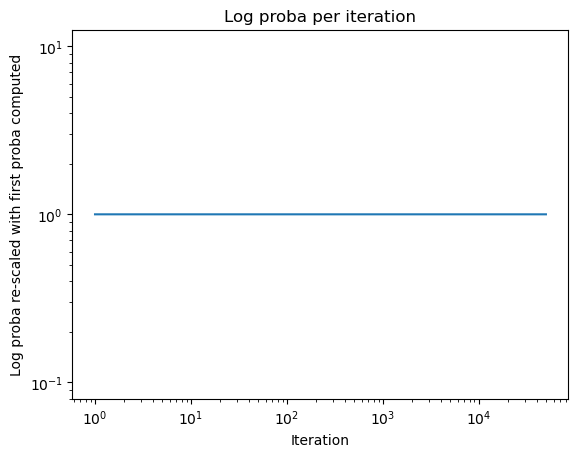

In [51]:
plt.plot(np.arange(number_steps_sampler)+1, log_proba_samples)
plt.title('Log proba per iteration')
plt.xlabel('Iteration')
plt.ylabel('Log proba re-scaled with first proba computed')
plt.loglog()
plt.show()

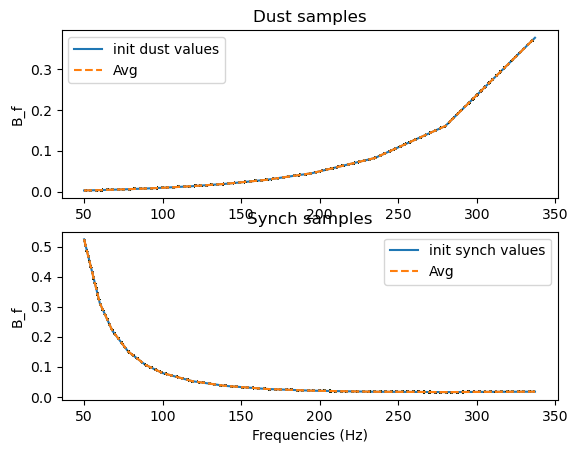

In [52]:
frequency_Bf = instrument['frequency'][1:-1]

plt.subplot(211)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='init dust values')
plt.plot(frequency_Bf, component_dust.T, ':', alpha=0.1)
plt.plot(frequency_Bf, component_dust.mean(axis=0), '--', label='Avg')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Dust samples')
# plt.loglog()
plt.legend()
# plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')

plt.subplot(212)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T, label='init synch values')
plt.plot(frequency_Bf, component_synchrotron.T, ':', alpha=0.1)
plt.plot(frequency_Bf, component_synchrotron.mean(axis=0), '--', label='Avg')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Synch samples')
# plt.loglog()
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')
plt.show()

In [53]:
number_element_column = int(samples.shape[-1]/2)


# all_ess = numpyro.diagnostics.effective_sample_size(samples[:,:,0,:])
all_ess = numpyro.diagnostics.effective_sample_size(samples[:,:,:])
print(all_ess.shape)
print(all_ess)

int_ess = np.where(np.int32(np.round(all_ess)) == 0, 1, np.int32(np.round(all_ess)))

all_samples_ESS = []
all_avg_ESS = np.empty(samples.shape[-1])
for i in range(samples.shape[-1]):
    # all_samples_ESS.append(samples[0,::int_ess[i],0,i])
    # all_avg_ESS[i] = np.average(samples[0,::int_ess[i],0,i])
    all_samples_ESS.append(samples[0,::int_ess[i],i])
    all_avg_ESS[i] = np.average(samples[0,::int_ess[i],i])


(26,)
[0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005
 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005
 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005
 0.500005 0.500005]


In [54]:
for i in range(len(all_samples_ESS)):
    print('Std :', np.std(all_samples_ESS[i]))

Std : 3.903127820947816e-18
Std : 5.204170427930421e-18
Std : 1.734723475976807e-18
Std : 6.938893903907228e-18
Std : 3.469446951953614e-18
Std : 1.734723475976807e-18
Std : 1.9081958235744878e-17
Std : 2.42861286636753e-17
Std : 3.122502256758253e-17
Std : 0.0
Std : 1.1102230246251565e-16
Std : 1.3877787807814457e-16
Std : 1.1102230246251565e-16
Std : 7.771561172376096e-16
Std : 3.885780586188048e-16
Std : 1.6653345369377348e-16
Std : 0.0
Std : 5.551115123125783e-17
Std : 2.7755575615628914e-17
Std : 7.632783294297951e-17
Std : 4.163336342344337e-17
Std : 3.122502256758253e-17
Std : 0.0
Std : 1.734723475976807e-17
Std : 3.469446951953614e-18
Std : 1.734723475976807e-17


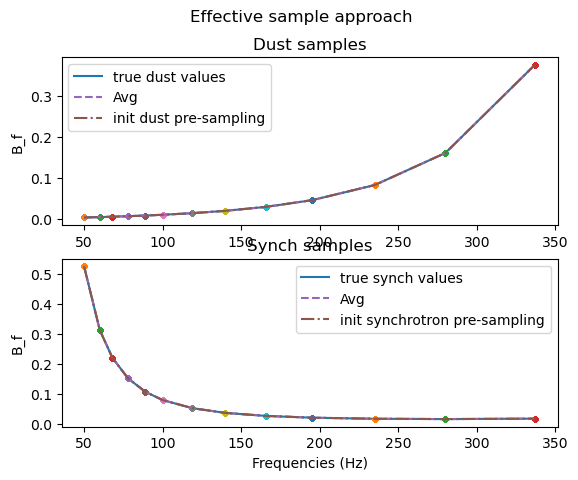

In [56]:
alpha_value = 0.5

frequency_Bf = instrument['frequency'][1:-1]
plt.suptitle("Effective sample approach")
plt.subplot(211)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='true dust values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), all_samples_ESS[i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), all_samples_ESS[i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, all_avg_ESS[:number_element_column], '--', label='Avg')
plt.plot(frequency_Bf, full_initial_guess[:int(dimensions_mixing_matrix/2)].T, '-.', label='init dust pre-sampling')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Dust samples')
# plt.loglog()
plt.legend()
# plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')

plt.subplot(212)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T, label='true synch values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), all_samples_ESS[number_element_column+i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), all_samples_ESS[number_element_column+i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, all_avg_ESS[number_element_column:], '--', label='Avg')
plt.plot(frequency_Bf, full_initial_guess[int(dimensions_mixing_matrix/2):].T, '-.', label='init synchrotron pre-sampling')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Synch samples')
# plt.loglog()
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')
plt.show()

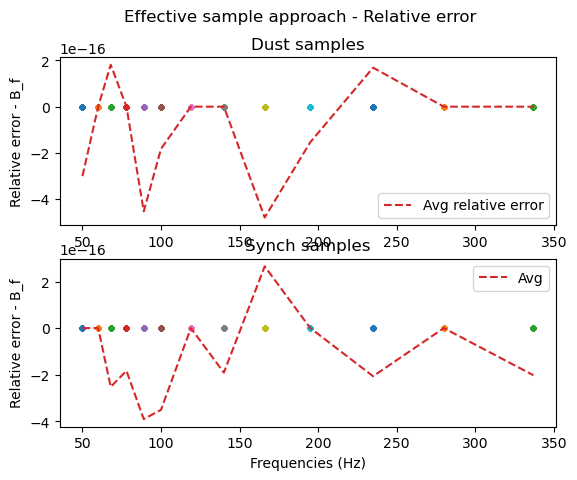

In [59]:
alpha_value = 0.5

frequency_Bf = instrument['frequency'][1:-1]
plt.suptitle("Effective sample approach - Relative error")
plt.subplot(211)
true_values = initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T
# plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='true dust values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), all_samples_ESS[i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), (all_samples_ESS[i]-true_values[i])/true_values[i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, (all_avg_ESS[:number_element_column]-true_values)/true_values, '--', label='Avg relative error')
# plt.plot(frequency_Bf, full_initial_guess[:,:int(dimensions_mixing_matrix/2)].T, '-.', label='init dust pre-sampling')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Dust samples')
# plt.loglog()
plt.legend()
# plt.xlabel('Frequencies (Hz)')
plt.ylabel('Relative error - B_f')

plt.subplot(212)
true_values = initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T
# plt.plot(frequency_Bf, true_values, label='true synch values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), all_samples_ESS[number_element_column+i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), (all_samples_ESS[number_element_column+i]-true_values[i])/true_values[i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, (all_avg_ESS[number_element_column:]-true_values)/true_values, '--', label='Avg')
# plt.plot(frequency_Bf, full_initial_guess[:,int(dimensions_mixing_matrix/2):].T, '-.', label='init synchrotron pre-sampling')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Synch samples')
# plt.loglog()
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Relative error - B_f')
plt.show()

In [ ]:
# # ver = 'J1a'
# # filename_backend_mcmc = "validation_numpyro_step_4_SO_{}ver{}".format(nside,ver)
# # np.save(filename_backend_mcmc, samples_chain)

# ver = 'J0a'
# filename_backend_mcmc = "validation_numpyro_spectral_LKLD_{}_{}ver{}".format(instr_name, nside,ver)
# np.save(filename_backend_mcmc, samples_chain)

In [ ]:
chain_samples = mcmc.get_samples(group_by_chain=True)

In [ ]:
gelman_rubin_statistic = numpyro.diagnostics.gelman_rubin(chain_samples)
print(gelman_rubin_statistic.shape)
gelman_rubin_statistic

(8,)


array([ 2.37004277,  1.11387337,  4.00558247,  1.08546988,  4.27636892,
        1.00271842,  2.97649006, 13.27488369])

In [ ]:
gelman_rubin_statistic_0 = numpyro.diagnostics.gelman_rubin(np.mean(chain_samples,axis=2))
print(gelman_rubin_statistic_0.shape)
gelman_rubin_statistic_0

()


4.173108189485061

In [ ]:
gelman_rubin_statistic_2 = numpyro.diagnostics.gelman_rubin(chain_samples[:2])
print(gelman_rubin_statistic_2.shape)
gelman_rubin_statistic_2

(8,)


array([1.28471094, 2.42021836, 2.58464444, 2.02191194, 1.07191771,
       3.42065517, 2.39569205, 2.58386433])

In [ ]:
autocovariance.shape

(700, 1, 8)

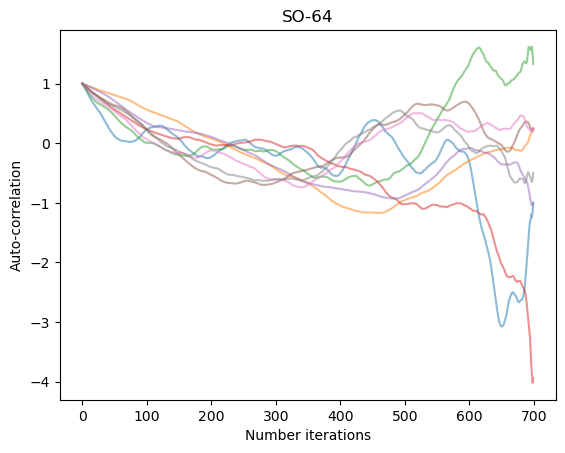

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocorrelation[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-correlation')
plt.show()

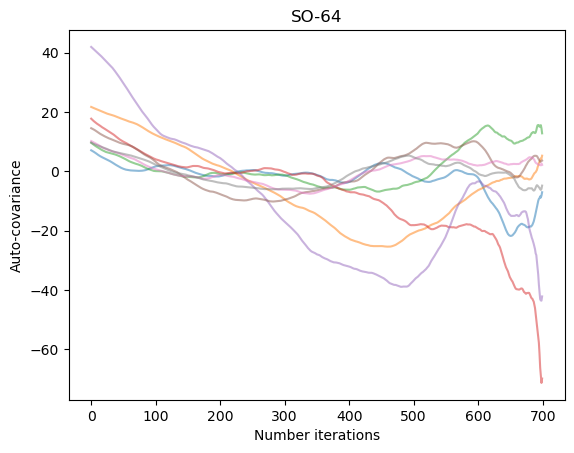

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocovariance[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-covariance')
plt.show()

In [ ]:
autocorrelation_times = np.array([1 + 2*(autocorrelation[i*100:(i+1)*100]/autocorrelation[i*100]).sum(axis=0) for i in range(7)])

In [ ]:
autocorrelation_times

array([[[   63.79095859,   161.09999382,    92.57021867,   118.28840687,
           140.00609   ,   127.25284414,   106.32375782,   124.70962088]],

       [[   36.13165418,   117.98385449, -3269.36898061,    88.14224889,
           128.78817579,  -166.22666612,  -386.79518031,  -109.06069047]],

       [[   57.40231003,  -417.4126455 ,   200.64159748,   -49.771898  ,
          -237.7484772 ,   245.3334249 ,   576.9414696 ,   277.548081  ]],

       [[  252.02666278,   327.10426618,   687.17852401,  2473.33222267,
           311.9451764 ,   135.31273953,   197.66334663,   169.83234917]],

       [[  -22.84121669,   213.27659937,   183.99638445,   331.68981548,
           224.29592965,  -114.16293229,   -55.83473957,  -462.63759895]],

       [[  192.70499288,   140.01772333,  -195.44609265,   204.70822879,
           111.9853972 ,   258.79124916,   194.04872554,    98.90293358]],

       [[ 1272.21949916,    78.94380689,   192.86804936,   358.05416182,
           835.13471414,    55.03

In [ ]:
import emcee.autocorr

In [ ]:
# https://github.com/dfm/emcee/blob/59b6a34323022bc547c3a9fb2173cbffe806af9b/src/emcee/backends/backend.py#L130
emcee.autocorr.integrated_time(samples, tol=0)

array([59.53177363, 85.31270358, 57.24913837, 91.02485449, 81.28128676,
       48.91212108, 53.95907357, 52.25562043])

In [ ]:
mixing_matrix_sampled = last_sample

In [ ]:
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

In [ ]:
hp.mollview(residual_post_sampling[0][0])
hp.mollview(residual_post_sampling[0][1])

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)